# Assignment 1: This is the title of the assignment

Authors:  
Lina Hagberg  
Ella Villför  

## Imports

ToDo: 
* Rensa bland viderona 
* Dela upp i träning 
* .MOV funkar ej

In [62]:
# It is recommended to start with general import statements
from utility_functions import *
import ultralytics
ultralytics.checks()
import cv2
from ultralytics import YOLO
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split


Ultralytics 8.3.88 🚀 Python-3.10.13 torch-2.6.0 CPU (Apple M1)
Setup complete ✅ (8 CPUs, 16.0 GB RAM, 220.0/228.3 GB disk)


## Load data

This section should load the raw dataset for the task.  
Remember to use relative paths to load any files in the notebook.

In [20]:
# Data to calssify: barbell biceps curl, bench press, deadlift, plank, pull up, push up, shoulder press and squat

# Load the YOLOv8 model
model = YOLO('yolov8n-pose.pt', verbose=False)

# Path to the main dataset folder
dataset_path = "raw_data" 
output_csv = "keypoints_dataset.csv"
num_keypoints = 17 * 2  # 17 keypoints 34 total value
num_frames = 200

X = []
Y = []

# Iterate over each subfolder (exercise category)
for exercise_folder in os.listdir(dataset_path):
    if exercise_folder == ".DS_Store":
        continue
    
    exercise_path = os.path.join(dataset_path, exercise_folder)
    print(f"Processing: {exercise_path}")

    
    # Ensure it's a directory
    if not os.path.isdir(exercise_path):
        continue
    
    # Iterate over each video in the exercise folder
    for video_file in os.listdir(exercise_path):
        video_path = os.path.join(exercise_path, video_file)
        
        # Ensure it's a video file (basic check)
        if not video_file.lower().endswith((".mp4", ".mov")):
            continue
        
        cap = cv2.VideoCapture(video_path)
        keypoints_list = []

        # Loop through the video frames
        while cap.isOpened():
            # Read a frame from the video
            success, frame = cap.read()

            if not success:
                break

            # Run YOLOv8 tracking on the frame, persisting tracks between frames
            results = model.track(frame, persist=True, tracker ='bytetrack.yaml', conf=0.05, classes=0, verbose=False)

            # Extract keypoints (Handle cases where no person is detected)
            if results[0].keypoints is not None:
                # Takes the most confident person (fisrt person in list)
                keypoints = results[0].keypoints.xy.cpu().numpy()[0].flatten()
            else:
                keypoints = np.zeros(num_keypoints)  # Fill with zeros if no keypoints detected

            # Ensure keypoints are always 34 values
            if len(keypoints) > num_keypoints:
                print(f"Warning: Expected {num_keypoints} keypoints, got {len(keypoints)}. Only keeping 34 first - {video_file}")
                keypoints = keypoints[:num_keypoints]  # Trim to match expected length
                
            elif len(keypoints) < num_keypoints:
                print(f"Warning: Expected {num_keypoints} keypoints, got {len(keypoints)}.Filling with zeros - {video_file}")
                keypoints = np.pad(keypoints, (0, num_keypoints - len(keypoints)), 'constant')

            # Append to DataFrame
            keypoints_list.append(keypoints)

        cap.release()

        keypoints_list = np.array(keypoints_list)
        
        if len(keypoints_list) < num_frames:
            # Padding
            keypoints_list_adj = np.pad(keypoints_list, ((0, num_frames - keypoints_list.shape[0]), (0, 0)),  'constant')

            #keypoints_list = np.pad(keypoints_list, (0, num_frames - len(keypoints_list)), 'constant')
        elif len(keypoints_list) > num_frames:
            # Trim
            keypoints_list_adj = keypoints_list[:num_frames]
            
        X.append(keypoints_list_adj)
        Y.append(exercise_folder)

        if exercise_folder == "plank" and keypoints_list.shape[0] > num_frames*2:
            keypoints_list_adj = keypoints_list[keypoints_list.shape[0]-num_frames:keypoints_list.shape[0]]
            X.append(keypoints_list_adj)
            Y.append(exercise_folder)



# Convert to NumPy arrays
X_numpy = np.array(X)  # Shape: (num_videos, 200, 34)
Y_numpy = np.array(Y)  # Labels

print(f"Shape X: {X_numpy.shape}")  # Should be (num_videos, 200, 34)
print(f"Shape Y: {Y_numpy.shape}")  # Should be (num_videos,)


Processing: raw_data/test
Shape X: (1, 200, 34)
Shape Y: (1,)


In [38]:
# Load the YOLOv8 model
model = YOLO('yolov8n-pose.pt', verbose=False)

# Path to the main dataset folder
dataset_path = "raw_data" 
output_csv = "keypoints_dataset.csv"
num_keypoints = 17 * 2  # 17 keypoints 34 total value
num_frames = 150 # Ca 4-5 seconds

X = []
Y = []

# Iterate over each subfolder (exercise category)
for exercise_folder in os.listdir(dataset_path):
    if exercise_folder == ".DS_Store":
        continue
    
    exercise_path = os.path.join(dataset_path, exercise_folder)
    print(f"Processing: {exercise_path}")

    
    # Ensure it's a directory
    if not os.path.isdir(exercise_path):
        continue
    
    # Iterate over each video in the exercise folder
    for video_file in os.listdir(exercise_path):
        video_path = os.path.join(exercise_path, video_file)
        
        # Ensure it's a video file (basic check)
        if not video_file.lower().endswith((".mp4", ".mov")):
            continue
        
        cap = cv2.VideoCapture(video_path)
        keypoints_list = []

        # Loop through the video frames
        while cap.isOpened():
            # Read a frame from the video
            success, frame = cap.read()

            if not success:
                break

            # Run YOLOv8 tracking on the frame, persisting tracks between frames
            results = model.track(frame, persist=True, tracker ='bytetrack.yaml', conf=0.05, classes=0, verbose=False)

            # Extract keypoints (Handle cases where no person is detected)
            if results[0].keypoints is not None:
                # Takes the most confident person (fisrt person in list)
                keypoints = results[0].keypoints.xy.cpu().numpy()[0].flatten()
            else:
                keypoints = np.zeros(num_keypoints)  # Fill with zeros if no keypoints detected

            # Ensure keypoints are always 34 values
            if len(keypoints) > num_keypoints:
                print(f"Warning: Expected {num_keypoints} keypoints, got {len(keypoints)}. Only keeping 34 first - {video_file}")
                keypoints = keypoints[:num_keypoints]  # Trim to match expected length 
                
            elif len(keypoints) < num_keypoints:
                print(f"Warning: Expected {num_keypoints} keypoints, got {len(keypoints)}.Filling with zeros - {video_file}")
                keypoints = np.pad(keypoints, (0, num_keypoints - len(keypoints)), 'constant')

            # Append to DataFrame
            keypoints_list.append(keypoints)

        cap.release()

        keypoints_list = np.array(keypoints_list)

        # Section video to lenght num_frames
        if len(keypoints_list) < num_frames:
            # Padding
            keypoints_list_adj = np.pad(keypoints_list, ((0, num_frames - keypoints_list.shape[0]), (0, 0)),  'constant')
            X.append(keypoints_list_adj)
            Y.append(exercise_folder)

        elif len(keypoints_list) > num_frames:
            num_sectsions = len(keypoints_list)//num_frames 
            
            # Devide data
            for i in range(num_sectsions):
                start_idx = i * num_frames
                end_idx = start_idx + num_frames  # Ensuring correct slicing
                keypoints_list_adj = keypoints_list[start_idx : end_idx]
                X.append(keypoints_list_adj)
                Y.append(exercise_folder)
            
            # Handle remaining frames
            remainder = len(keypoints_list) % num_frames
            if remainder > 0:
                keypoints_list_adj = np.pad(keypoints_list[-remainder:], ((0, num_frames - remainder), (0, 0)), 'constant')
                X.append(keypoints_list_adj)
                Y.append(exercise_folder)



# Convert to NumPy arrays
X_numpy = np.array(X)  # Shape: (num_videos, 200, 34)
Y_numpy = np.array(Y)  # Labels

print(f"Shape X: {X_numpy.shape}")  # Should be (num_videos, 200, 34)
print(f"Shape Y: {Y_numpy.shape}")  # Should be (num_videos,)


Processing: raw_data/deadlift
Processing: raw_data/barbell biceps curl
Processing: raw_data/shoulder press
Processing: raw_data/bench press
Processing: raw_data/pull Up
Shape X: (276, 150, 34)
Shape Y: (276,)


Unique values: ['barbell biceps curl' 'bench press' 'deadlift' 'pull Up' 'shoulder press']
Count: [75 69 34 56 42]


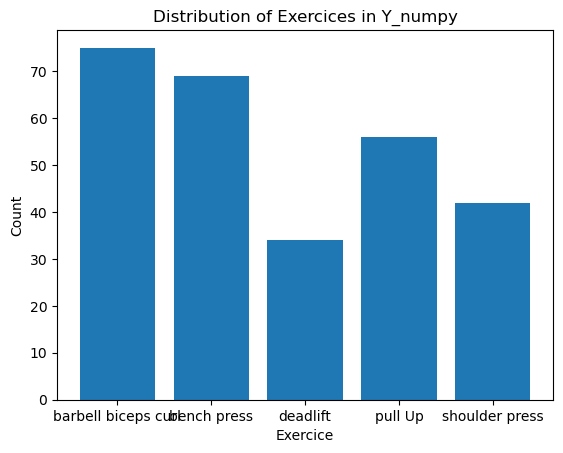

In [39]:
unique_values, counts = np.unique(Y_numpy, return_counts=True)

print(f"Unique values: {unique_values}")
print(f"Count: {counts}")

# Plot the distribution
plt.bar(unique_values, counts, tick_label=unique_values)
plt.xlabel("Exercice")
plt.ylabel("Count")
plt.title("Distribution of Exercices in Y_numpy")
plt.show()

In [41]:
# Save data to CSV

def saveToCsv(filename, X, Y):


    temp = []

    for i in range(Y.shape[0]):
        if Y[i] == filename:
            temp.append(X[i,:,:])

    # Convert list of arrays into a NumPy array
    temp_numpy = np.array(temp)  # Shape: (num_squat_samples, 200, 29)

    # Reshape into a 2D format for CSV (flattening each video sequence)
    num_samples, num_frames, num_features = temp_numpy.shape
    temp_reshaped = temp_numpy.reshape(num_samples, num_frames * num_features)

    # Convert to Pandas DataFrame
    temp_df = pd.DataFrame(temp_reshaped)

    # Save to CSV
    temp_df.to_csv(f"{filename}.csv", index=False)

    print("CSV file saved successfully")

# Save all data to 
saveToCsv("barbell biceps curl", X_numpy, Y_numpy)
saveToCsv("bench press", X_numpy, Y_numpy)
saveToCsv("deadlift", X_numpy, Y_numpy)
#saveToCsv("plank", X_numpy, Y_numpy)
saveToCsv("pull Up", X_numpy, Y_numpy)
#saveToCsv("push-up", X_numpy, Y_numpy)
saveToCsv("shoulder press", X_numpy, Y_numpy)
#saveToCsv("squat", X_numpy, Y_numpy)


CSV file saved successfully
CSV file saved successfully
CSV file saved successfully
CSV file saved successfully
CSV file saved successfully


In [44]:
# Load csv

def load_csv(filename, num_frames):

    # Load the CSV file
    load_df = pd.read_csv(f"processed_data/{filename}")

    # Convert DataFrame to NumPy array
    load_numpy = load_df.to_numpy()  # Shape: (num_samples, 5800)

    # Reshape back to original (samples, 200, 29)
    num_samples = load_numpy.shape[0]
    num_features = 34

    X_load = load_numpy.reshape(num_samples, num_frames, num_features)
    name = filename.replace(".csv", "")
    Y_load = np.array([name] * X_load.shape[0])

    print(f"Restored Shape: {X_load.shape}")  # Expected: (num_samples, 200, 29)

    return X_load, Y_load

X = []
Y = []

for exercise_csv in os.listdir("processed_data"):
    if exercise_csv == ".DS_Store":
        continue
    print(f"{exercise_csv}")
    x_temp, y_temp = load_csv(exercise_csv, num_frames)
    X.append(x_temp)
    Y.append(y_temp)

X_numpy = np.concatenate(X) # Stack along samples axis
Y_numpy = np.concatenate(Y) # Labels

print(f"Shape X_numpy: {X_numpy.shape}")  # Should be (num_videos, 200, 34)
print(f"Shape Y_numpy: {Y_numpy.shape}")  # Should be (num_videos,)


plank.csv
Restored Shape: (70, 150, 34)
push-up.csv
Restored Shape: (40, 150, 34)
squat.csv
Restored Shape: (69, 150, 34)
deadlift.csv
Restored Shape: (34, 150, 34)
pull Up.csv
Restored Shape: (56, 150, 34)
bench press.csv
Restored Shape: (69, 150, 34)
shoulder press.csv
Restored Shape: (42, 150, 34)
barbell biceps curl.csv
Restored Shape: (75, 150, 34)
Shape X_numpy: (455, 150, 34)
Shape Y_numpy: (455,)


In [45]:

X_body = X_numpy[:,:,8:]
print(f"Shape X: {X_body.shape}")  # Should be (num_videos, 200, 26)

Shape X: (455, 150, 26)


Unique values: ['barbell biceps curl' 'bench press' 'deadlift' 'plank' 'pull Up' 'push-up' 'shoulder press' 'squat']
Count: [75 69 34 70 56 40 42 69]


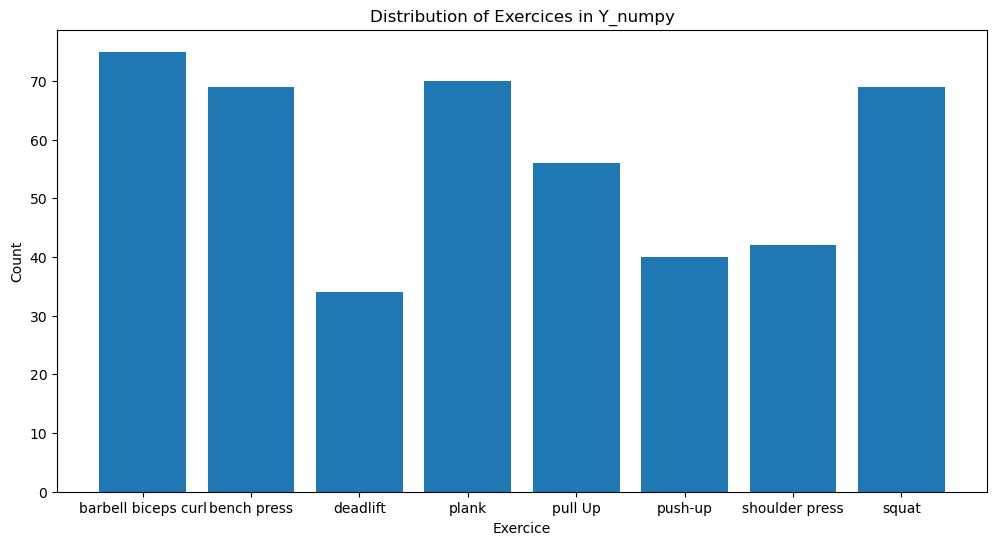

In [53]:
unique_values, counts = np.unique(Y_numpy, return_counts=True)

print(f"Unique values: {unique_values}")
print(f"Count: {counts}")

# Plot the distribution
plt.figure(figsize=(12,6))
plt.bar(unique_values, counts, tick_label=unique_values)
plt.xlabel("Exercice")
plt.ylabel("Count")
plt.title("Distribution of Exercices in Y_numpy")
plt.show()

In [ ]:
# Dictionary that maps from joint names to keypoint indices.
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

# Maps bones to a matplotlib color name.
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

## Task 1: Create and train a model

This section should contain the solution of task 1.

It is mandatory to maintain the headings for each task.  
OPTIONALLY, you can use one level down (###) to organize subsessions of the assignments.

In [63]:
import tensorflow as tf

# Convert labels to categorical (one-hot encoding)
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y = encoder.fit_transform(Y_numpy)  # Convert string labels to numbers
y = tf.keras.utils.to_categorical(y)  # One-hot encode labels

X_train, X_test, y_train, y_test = train_test_split(X_body, y, test_size=0.3, random_state=42)
print(f"Shape X: {X_train.shape}")  # Should be (205, 150, 26)

Shape X: (318, 150, 26)


Epoch 1/30
10/10 [==============================] - 4s 186ms/step - loss: 2.6446 - accuracy: 0.1384 - val_loss: 2.0465 - val_accuracy: 0.2628 - lr: 5.0000e-04
Epoch 2/30
10/10 [==============================] - 1s 136ms/step - loss: 2.1993 - accuracy: 0.1918 - val_loss: 2.0066 - val_accuracy: 0.2847 - lr: 5.0000e-04
Epoch 3/30
10/10 [==============================] - 1s 143ms/step - loss: 2.0422 - accuracy: 0.2516 - val_loss: 1.9603 - val_accuracy: 0.3431 - lr: 5.0000e-04
Epoch 4/30
10/10 [==============================] - 1s 138ms/step - loss: 1.8807 - accuracy: 0.3239 - val_loss: 1.9127 - val_accuracy: 0.4088 - lr: 5.0000e-04
Epoch 5/30
10/10 [==============================] - 1s 137ms/step - loss: 1.7696 - accuracy: 0.3491 - val_loss: 1.8669 - val_accuracy: 0.4307 - lr: 5.0000e-04
Epoch 6/30
10/10 [==============================] - 1s 138ms/step - loss: 1.6626 - accuracy: 0.4088 - val_loss: 1.8086 - val_accuracy: 0.3942 - lr: 5.0000e-04
Epoch 7/30
10/10 [============================

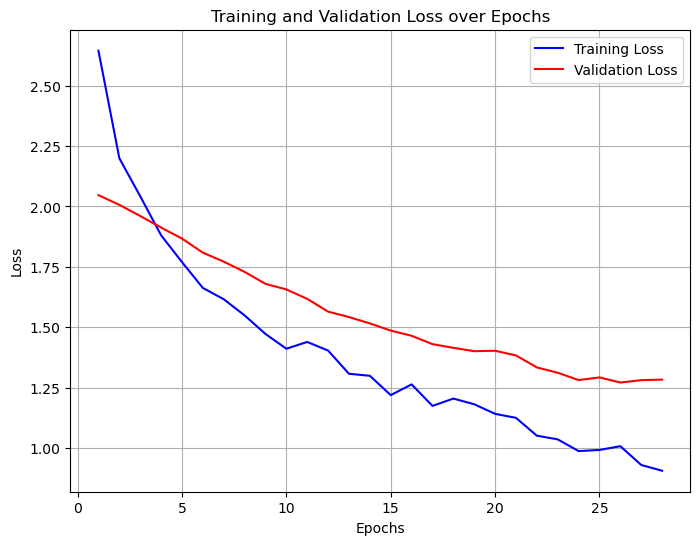

In [81]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, BatchNormalization
from tensorflow.keras.regularizers import l2
import pandas as pd

# Define LSTM model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(150, 26)),
    BatchNormalization(),
    Dropout(0.3),

    LSTM(64, return_sequences=False),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    Dense(8, activation='softmax') 
])

# Compile model
optimizer = Adam(learning_rate=0.0005, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)   
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-5, verbose=1)

# Train model
history = model.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, lr_scheduler]
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)

# Print results
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}")


# === Compare training and validation loss ===

# Extract loss and validation loss from training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()



Test Loss: 1.2683
Test Accuracy: 59.12
5/5 [==============================] - 1s 21ms/step
                     precision    recall  f1-score   support

barbell biceps curl       0.60      0.50      0.55        24
        bench press       0.43      0.65      0.52        20
           deadlift       0.50      0.56      0.53         9
              plank       0.69      0.83      0.75        29
            pull Up       0.62      0.53      0.57        15
            push-up       0.75      0.60      0.67        15
     shoulder press       0.56      0.56      0.56         9
              squat       0.62      0.31      0.42        16

           accuracy                           0.59       137
          macro avg       0.60      0.57      0.57       137
       weighted avg       0.61      0.59      0.59       137



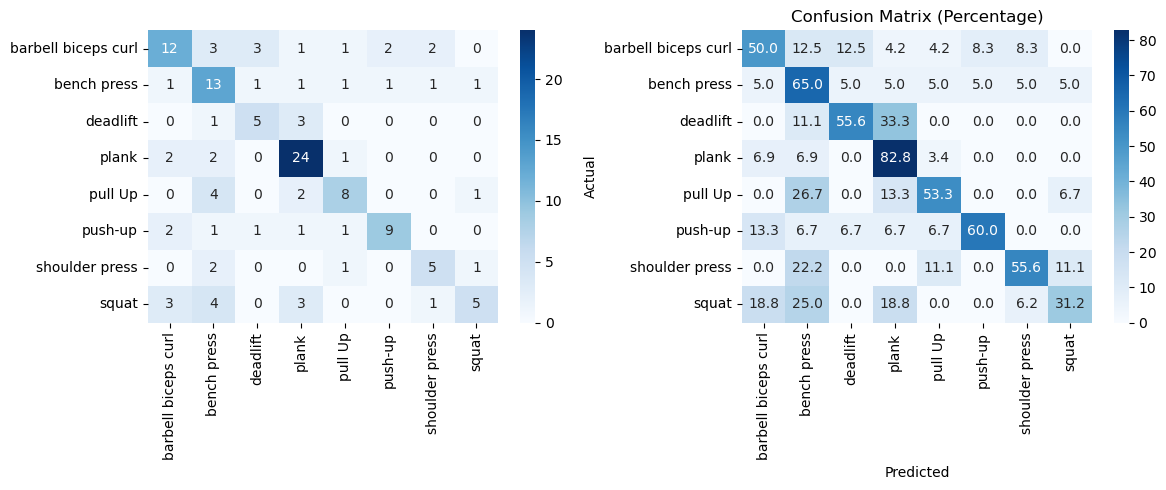

In [78]:
from sklearn.metrics import classification_report
import numpy as np
# Print results
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}")

# Get predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
y_true_classes = np.argmax(y_test, axis=1)  # Convert one-hot encoding back to labels

# Print classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=encoder.classes_))

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
# Compute confusion matrix as percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100

# Plot both confusion matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=encoder.classes_, yticklabels=encoder.classes_, ax=axes[0])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

# Confusion matrix as percentages
sns.heatmap(cm_percentage, annot=True, fmt=".1f", cmap="Blues", xticklabels=encoder.classes_, yticklabels=encoder.classes_, ax=axes[1])
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")
axes[1].set_title("Confusion Matrix (Percentage)")

plt.tight_layout()
plt.show()


Use markdown cells like this one to include:
- Discussion points.
- References to specific sources of code that you might have used to solve the assignment.
- General commentas and explanations about your solution.

In [ ]:
# Always use comments in the code to document specific steps

## Task 2: This is the title of task 2

This section should contain the solution of task 2.

## Results and Discussion

In [ ]:
# Always use comments in the code to document specific steps

This section should contain:
- Results.
- Summary of best model performance:
    - Name of best model file as saved in /models.
    - Relevant scores such as: accuracy, precision, recall, F1-score, etc.
- Key discussion points.